# Matrix Completion

La "matrix completion" (completamento di matrice) è un problema nel campo dell'apprendimento automatico e della statistica che riguarda il recupero di valori mancanti in una matrice a partire da un insieme di valori osservati. In molti scenari del mondo reale, i dati possono essere incompleti a causa di vari motivi come errori di misurazione, mancanza di campionamento o dati mancanti per altre ragioni.

Il problema del completamento della matrice si pone quando vogliamo stimare o "completare" i valori mancanti in una matrice in modo che la matrice risultante sia coerente con le informazioni osservate. Formalmente, se abbiamo una matrice M di dimensioni m×n con alcuni elementi mancanti (rappresentati spesso da valori mancanti o zero), il completamento della matrice cerca di predire o stimare i valori mancanti in modo che la matrice completa sia una buona approssimazione della matrice originale.

[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.
 
This data set consists of:
- 100000 ratings (1-5) from 943 users on 1682 movies. 
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of 

```
user id | item id | rating | timestamp
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

## Reading data with Pandas

In [2]:
dataset = pd.read_csv('movielens.csv', sep = '\t', header = None)
dataset.describe()

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [3]:
rows = np.array(dataset[0]) - 1
cols = np.array(dataset[1]) - 1
vals = np.array(dataset[2]) 
print("Number of People: "+str(rows.max() + 1))
print("Number of Movies: "+str(cols.max() + 1))
print("Number of Ratings: "+str(len(vals)))

Number of People: 943
Number of Movies: 1682
Number of Ratings: 100000


Shuffle the data with `np.random.shuffle`

In [46]:
idxs = np.arange(len(vals))

np.random.seed(1)
np.random.shuffle(idxs)

rows = rows[idxs]
cols = cols[idxs]
vals = vals[idxs]

users = rows.max() + 1
movies = cols.max() + 1
ratings = len(rows)
print(ratings)

100000


Splitting dataset into a subset of 80000 **training ratings** and 20000 **testing ratings**.

In [4]:
training_index = 80000

train_rows = rows[:training_index]
train_cols = cols[:training_index]
train_ratings = vals[:training_index]

test_rows = rows[training_index:]
test_cols = cols[training_index:]
test_ratings = vals[training_index:]

test_ratings.shape


(20000,)

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:
$$
X_{i,j} = 
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$

In [49]:
X_sparse = csr_matrix((train_ratings, (train_rows,train_cols)), shape = (users, movies))
#Compressed Sparse Row, a specific data structure used in numerical computations
#particularly in the context of large sparse matrices. Sparse matrices are those 
#that contain a large number of zero elements.
#The CSR matrix format stores only the non-zero elements and their corresponding
#row and column indices. 
#It consists of three one-dimensional arrays.

X_full = X_sparse.toarray()
X_full.shape

(943, 1682)

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:
$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$
where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):
$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$
and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):
$$
\rho = 
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}} 
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}} 
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}} 
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$
where
$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} 
       r_{ij} 
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} 
       r^{\text{pred}}_{ij} 
\end{split}
$$

In [54]:
avg_ratings = np.array([np.mean(train_ratings[train_rows == i]) for i in range(users)])
#Cycling the user and getting ratings for that user -> calculating the MEAN
ratings_trivial = avg_ratings[test_rows]
#It creates a new array vals_trivial containing the values from avg_ratings corresponding to the indices in rows_test.

errors_trivial = test_ratings - ratings_trivial

RMSE_trivial = np.sqrt(np.mean(errors_trivial**2))
rho_trivial = pearsonr(test_ratings, ratings_trivial)[0] #Pearson correlation coefficient

print('RMSE: %1.3f' % RMSE_trivial)
print('rho : %1.3f' % rho_trivial)

RMSE: 1.041
rho : 0.374


## Singular value truncation (SVT) based recommender system

Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

**SVT is a SVD with a threshold value. The main steps of the SVT algorithm involve utilizing the Singular Value Decomposition (SVD) of the given matrix and applying a thresholding operation to the singular values. By setting small singular values to zero and retaining the significant ones, SVT effectively reduces the rank of the matrix, thus enabling the reconstruction of a low-rank approximation of the original matrix.**

Try to calibrate the threshold to get better results.

In [56]:
n_max_iter = 100
threshold  = 100.0
increment_tol = 1e-6

RMSE_list = list()
rho_list = list()

A = X_full.copy()
for i in range(n_max_iter):
    A_old = A.copy()
    U,s,VT = np.linalg.svd(A, full_matrices = False)

    s[s < threshold] = 0 #set singular values s to 0 where they are less than the threshold.
    A = U @ np.diag(s) @ VT #It reconstructs A using the modified singular values, updating the matrix.

    A[train_rows,train_cols] = train_ratings
    increment = np.linalg.norm(A - A_old) 

    ratings_predicted = A[test_rows,test_cols]
    errors = test_ratings - ratings_predicted

    RMSE_list.append(np.sqrt(np.mean(errors**2)))
    rho_list.append(pearsonr(test_ratings,ratings_predicted)[0])

    print('=============== Iteration %d - increment norm %1.3e' % (i+1, increment))
    print('RMSE: %1.3f' % RMSE_list[-1])
    print('rho:  %1.3f' % rho_list[-1])
    if increment < increment_tol:
        break

=============== Iteration 1 - increment norm 4.297e+02
RMSE: 2.637
rho:  0.307
=============== Iteration 2 - increment norm 2.575e+02
RMSE: 2.189
rho:  0.336
=============== Iteration 3 - increment norm 1.840e+02
RMSE: 1.938
rho:  0.358
=============== Iteration 4 - increment norm 1.432e+02
RMSE: 1.775
rho:  0.376
=============== Iteration 5 - increment norm 1.171e+02
RMSE: 1.660
rho:  0.390
=============== Iteration 6 - increment norm 9.888e+01
RMSE: 1.573
rho:  0.401
=============== Iteration 7 - increment norm 8.549e+01
RMSE: 1.506
rho:  0.411
=============== Iteration 8 - increment norm 7.523e+01
RMSE: 1.453
rho:  0.420
=============== Iteration 9 - increment norm 6.712e+01
RMSE: 1.409
rho:  0.427
=============== Iteration 10 - increment norm 6.056e+01
RMSE: 1.372
rho:  0.434
=============== Iteration 11 - increment norm 5.515e+01
RMSE: 1.341
rho:  0.440
=============== Iteration 12 - increment norm 5.061e+01
RMSE: 1.315
rho:  0.445
=============== Iteration 13 - increment norm 4.6

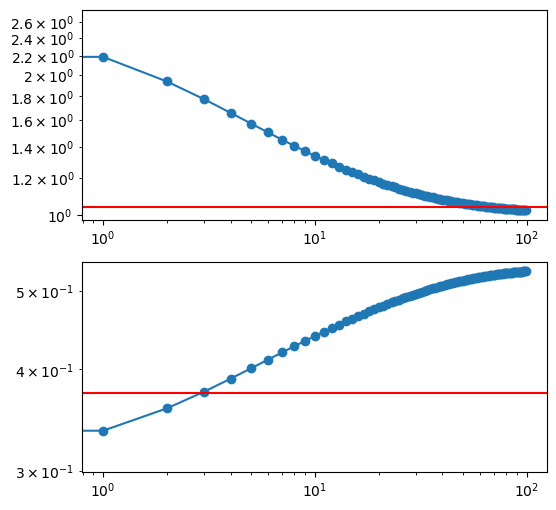

In [58]:
fig, axs = plt.subplots(2,1,figsize = (6,6))

axs[0].loglog(RMSE_list, 'o-')
axs[0].axhline(RMSE_trivial, color = 'red')

axs[1].loglog(rho_list, 'o-')
axs[1].axhline(rho_trivial, color = 'red')